In [9]:
import shap
shap.initjs()
import boto3
import numpy as np
import pandas as pd
import xgboost as xgb
import math

In [10]:
hyperparams = {'subsample': 0.6, 'num_round': 1000, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 1}
features = ['DIplus', 'cmf_15MA_diff', 'DMplus', 'roc', 'DMminus', 'cd_vol', 'return_vol_5D', 'price_5Ddiff', 'volume_sum15_5DMA_diff', 'H-L', 'cmf_15MA', 'max_30_diff', 'roc5', 'SPY_range_vol', 'Low-Close', 'High-Close', 'rsiH_15MA_diff', 'H-PrevClose', 'hour', 'bb_trend', 'close_10DMA_diff', 'SPY_20d_diff', 'rsiH', 'close_20DMA_diff', 'price_20Ddiff', 'range_vol_stddev40H_diff', 'SPY_5d_diff', 'return_vol_8H_diff', 'price_change_H', 'min_30_diff', 'day_of_week', 'cmf', 'price_range_H', 'rsi', 'roc3', 'bb_category', 'TR', 'roc_vol5', 'bb_spread', 'price_3D20D_diff', 'price_range_D', 'SPY_5d', 'roc_15MA_diff']

strategy = "CDBFC_1D"

In [11]:
def configure_dates(data,strategy):
    if strategy in ["CDBFC","CDBFP"]:
        data = data.loc[data['day_of_week'].isin([0,1,2])] 
    elif strategy in ["CDBFC_1D","CDBFP_1D"]:
        data = data.loc[data['day_of_week'].isin([0,1,2,3])]
    return data


data = pd.read_csv(f'/Users/charlesmiller/Documents/model_tester_data/BF/2015-01-01_2024-05-03EXP.csv')
data['dt'] = pd.to_datetime(data['date'])
data['one_max_vol'] = (data['one_max']/data['return_vol_5D']).round(3)
data['three_max_vol'] = (data['three_max']/data['return_vol_5D']).round(3)
data['one_min_vol'] = (data['one_min']/data['return_vol_5D']).round(3)
data['three_min_vol'] = (data['three_min']/data['return_vol_5D']).round(3)    
# data['one_max_vol30'] = (data['one_max']/data['return_vol_30D']).round(3)
# data['three_max_vol30'] = (data['three_max']/data['return_vol_30D']).round(3)
# data['one_min_vol30'] = (data['one_min']/data['return_vol_30D']).round(3)
# data['three_min_vol30'] = (data['three_min']/data['return_vol_30D']).round(3)    
# data['cd_vol'] = (data['close_diff']/data['return_vol_10D']).round(3)
# data['cd_vol3'] = (data['close_diff3']/data['return_vol_10D']).round(3)
# data['cd_vol30'] = (data['close_diff']/data['return_vol_30D']).round(3)
data['cd_vol'] = (data['price_change_D']/data['return_vol_5D']).round(3)
data['cd_vol3'] = (data['price_3Ddiff']/data['return_vol_5D']).round(3)
# data['cd_vol330'] = (data['close_diff3']/data['return_vol_30D']).round(3)
data = data.loc[data['symbol'].isin(["QQQ","SPY","IWM"])]
data = configure_dates(data,strategy)
data.replace([np.inf, -np.inf], 0, inplace=True)

In [12]:
train_value = math.floor(len(data)*0.8)
dataset = data.iloc[:train_value]
validation_dataset = data.iloc[train_value:]

target_label = 'one_max_vol'
target_value = dataset[target_label].quantile(0.6).round(3)

dataset.loc[:, 'label'] = (dataset[target_label] > target_value).astype(int)
validation_dataset.loc[:, 'label'] = (validation_dataset[target_label] > target_value).astype(int)

# dataset = dataset.round(3)
# validation_dataset = validation_dataset.round(3)

X = dataset[features].astype(float)
y = dataset['label']

X_validate = validation_dataset[features].astype(float)
y_validate = validation_dataset['label']


xgb_model = xgb.XGBClassifier(subsample=hyperparams['subsample'],num_round=hyperparams['num_round'],min_child_weight=hyperparams['min_child_weight'],max_depth=hyperparams['max_depth'],learning_rate=hyperparams['learning_rate'],gamma=hyperparams['gamma'],colsample_bytree=hyperparams['colsample_bytree'],verbosity=0,objective='binary:logistic',random_state=42)
xgb_model.fit(X, y,
       eval_set=[(X, y),
                 (X_validate, y_validate)
                ]
      )
# print(y.value_counts())
# predictions = xgb_model.predict(X_validate)
# probabilities = xgb_model.predict_proba(X_validate)



[0]	validation_0-logloss:0.65394	validation_1-logloss:0.67422
[1]	validation_0-logloss:0.63675	validation_1-logloss:0.67135
[2]	validation_0-logloss:0.62173	validation_1-logloss:0.66794
[3]	validation_0-logloss:0.60708	validation_1-logloss:0.66532
[4]	validation_0-logloss:0.59399	validation_1-logloss:0.66296
[5]	validation_0-logloss:0.58130	validation_1-logloss:0.66139
[6]	validation_0-logloss:0.57073	validation_1-logloss:0.65902
[7]	validation_0-logloss:0.56044	validation_1-logloss:0.66004
[8]	validation_0-logloss:0.55208	validation_1-logloss:0.66130
[9]	validation_0-logloss:0.54408	validation_1-logloss:0.66203
[10]	validation_0-logloss:0.53750	validation_1-logloss:0.66160
[11]	validation_0-logloss:0.53152	validation_1-logloss:0.66178
[12]	validation_0-logloss:0.52499	validation_1-logloss:0.66083
[13]	validation_0-logloss:0.51709	validation_1-logloss:0.66201
[14]	validation_0-logloss:0.50863	validation_1-logloss:0.66233
[15]	validation_0-logloss:0.50131	validation_1-logloss:0.66337
[1

/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_66938/251634766.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'label'] = (dataset[target_label] > target_value).astype(int)
/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_66938/251634766.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_dataset.loc[:, 'label'] = (validation_dataset[target_label] > target_value).astype(int)


[23]	validation_0-logloss:0.46788	validation_1-logloss:0.66993
[24]	validation_0-logloss:0.46413	validation_1-logloss:0.67009
[25]	validation_0-logloss:0.46026	validation_1-logloss:0.67077
[26]	validation_0-logloss:0.45644	validation_1-logloss:0.67325
[27]	validation_0-logloss:0.45324	validation_1-logloss:0.67373
[28]	validation_0-logloss:0.45052	validation_1-logloss:0.67388
[29]	validation_0-logloss:0.44697	validation_1-logloss:0.67519
[30]	validation_0-logloss:0.44188	validation_1-logloss:0.67657
[31]	validation_0-logloss:0.43979	validation_1-logloss:0.67680
[32]	validation_0-logloss:0.43569	validation_1-logloss:0.67840
[33]	validation_0-logloss:0.43291	validation_1-logloss:0.67887
[34]	validation_0-logloss:0.43137	validation_1-logloss:0.67916
[35]	validation_0-logloss:0.42849	validation_1-logloss:0.68014
[36]	validation_0-logloss:0.42620	validation_1-logloss:0.68071
[37]	validation_0-logloss:0.42214	validation_1-logloss:0.68072
[38]	validation_0-logloss:0.42025	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, num_round=1000, ...)

In [13]:
shap_ex = shap.TreeExplainer(xgb_model)
vals = shap_ex(X_validate)
shap_df = pd.DataFrame(vals.values, columns=X_validate.columns)

In [14]:
print(shap_df)

        DIplus  cmf_15MA_diff    DMplus       roc   DMminus    cd_vol  \
0     0.042477      -0.069029 -0.013827  0.339090  0.000086  0.067061   
1    -0.025436      -0.030608 -0.011828  0.147627  0.000132  0.070342   
2     0.105207       0.081065 -0.008094  0.349469  0.000086  0.036427   
3     0.052588      -0.069928 -0.008094  0.370530  0.000086  0.070460   
4    -0.024463      -0.086029 -0.005261  0.167262  0.000132  0.072705   
...        ...            ...       ...       ...       ...       ...   
6738  0.110403       0.020005  0.000888 -0.009592 -0.000087  0.007623   
6739  0.069307      -0.045279  0.000039 -0.030519 -0.000081 -0.005260   
6740  0.111672       0.032171  0.000526 -0.021906 -0.000087  0.004039   
6741  0.110750       0.034280  0.000379 -0.035496 -0.000087 -0.020201   
6742  0.120939      -0.054640  0.000240 -0.002061 -0.000065 -0.009366   

      return_vol_5D  price_5Ddiff  volume_sum15_5DMA_diff       H-L  ...  \
0         -1.665485      0.161696              

In [15]:
print(pd.concat([shap_df.sum(axis='columns')
.rename('pred') + vals.base_values,
pd.Series(y_validate, name='true')], axis='columns')
.assign(prob=lambda adf: (np.exp(adf.pred) / 
(1 + np.exp(adf.pred)))))

            pred  true      prob
0      -1.518985   NaN  0.179611
1      -1.594578   NaN  0.168741
2      -0.479407   NaN  0.382392
3      -0.904829   NaN  0.288059
4      -1.240374   NaN  0.224371
...          ...   ...       ...
422881       NaN   0.0       NaN
422882       NaN   1.0       NaN
422913       NaN   0.0       NaN
422914       NaN   1.0       NaN
422915       NaN   1.0       NaN

[13486 rows x 3 columns]


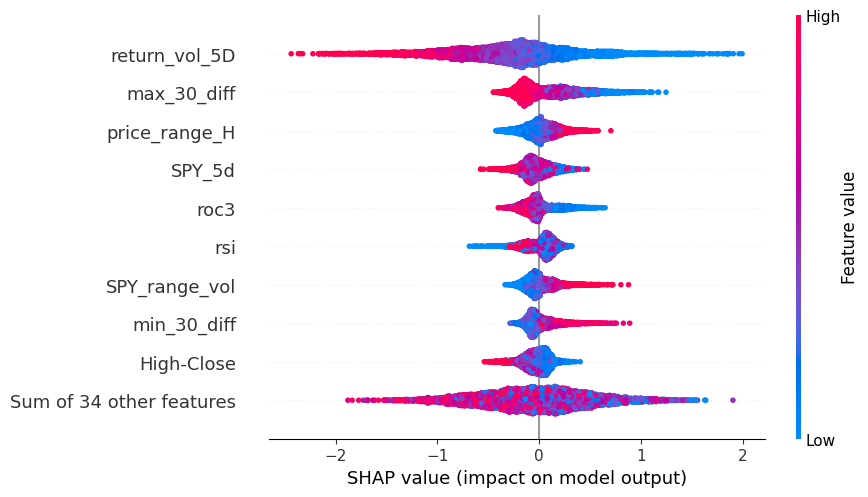

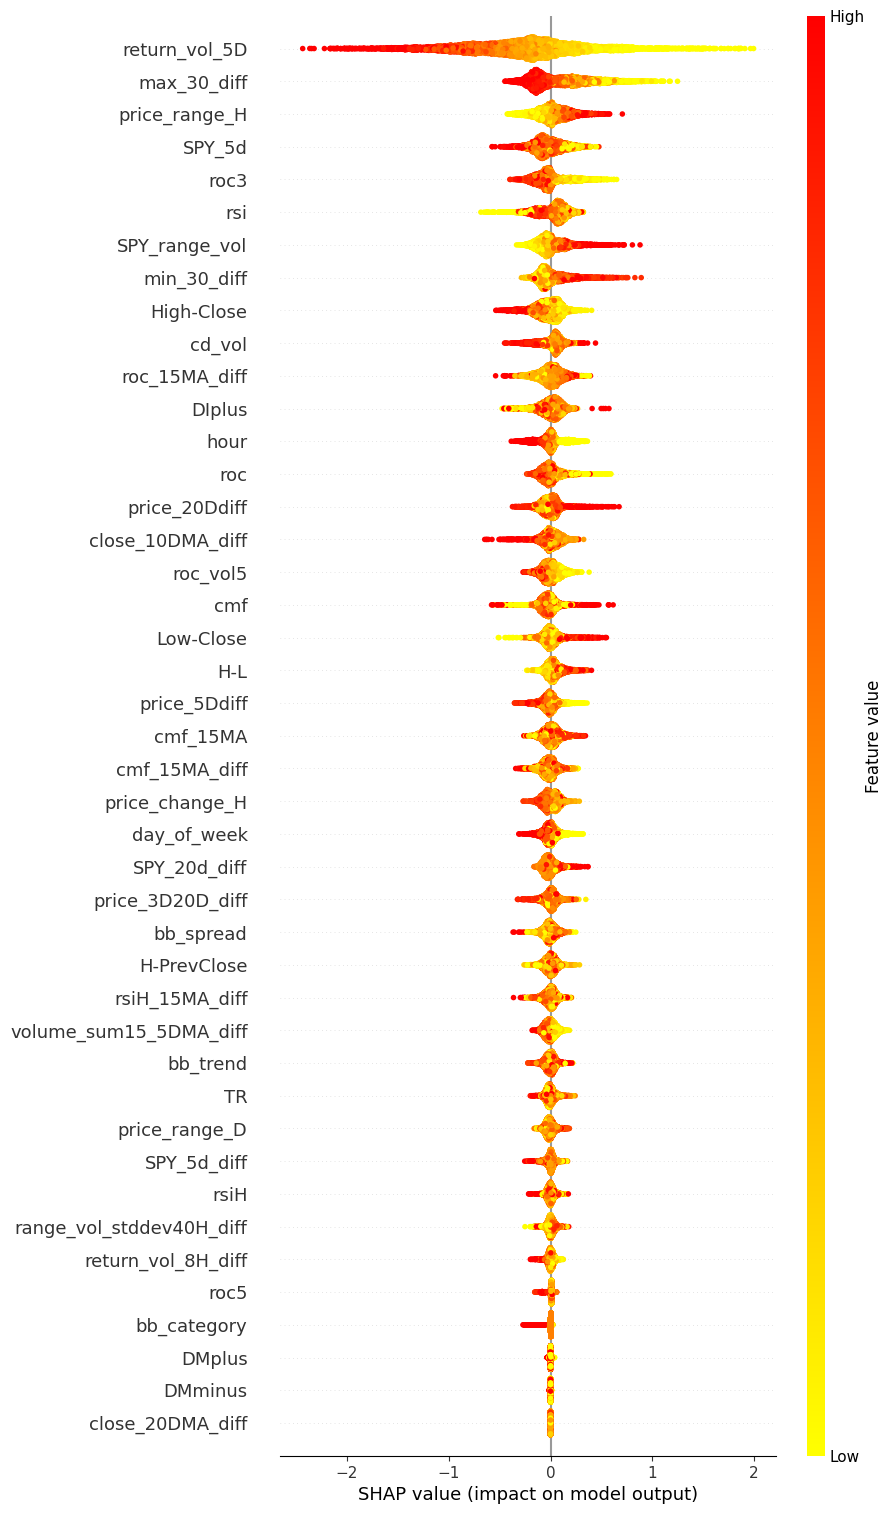

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals)

from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_validate.columns), color=cm.autumn_r)